In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config, preprocess
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (6, 6)

Using TensorFlow backend.


In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

In [7]:
gt = gt[2:-1]

In [8]:
gt[:, 1] = gt[:, 1] - 1

In [ ]:
re = RecordingExplorer(path_to_standarized, spike_size=15)
se = SpikeTrainExplorer(gt, re)

In [ ]:
def spike_amplitudes_from_spikes(spikes):
    return np.max(np.abs(spikes), axis=(0, 1))

In [11]:
amps = spike_amplitudes_from_spikes(se.templates)

In [12]:
np.argsort(amps)

array([22, 40, 46, 32, 43, 20, 21,  2, 29, 34, 12, 47, 35, 11, 14, 37, 13,
       38, 41, 39, 31, 30,  6, 10, 42, 24, 15, 45, 16,  1, 36, 44, 33, 17,
       48, 19,  0,  7, 28, 26,  4, 23, 18,  3, 25, 27,  8,  5,  9])

In [13]:
amps[[8, 5, 9]]

array([30.884478, 42.622433, 59.108902], dtype=float32)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


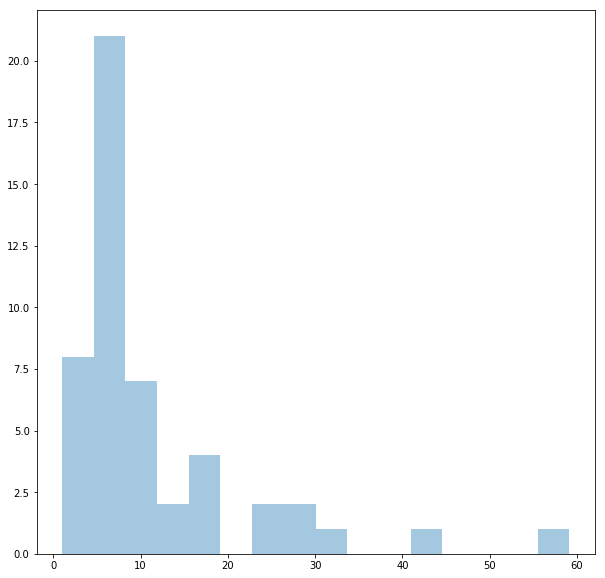

In [14]:
sns.distplot(amps, kde=False)

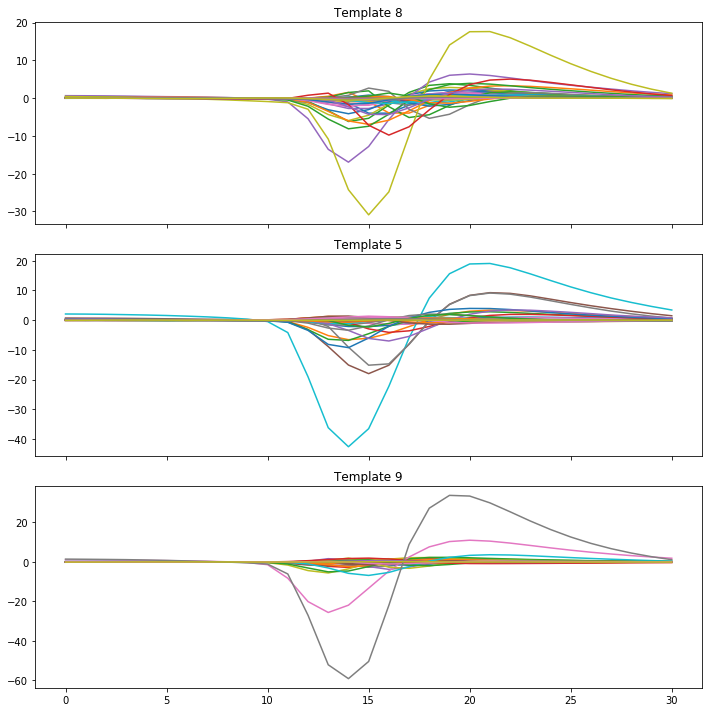

In [15]:
se.plot_templates(group_ids=[8, 5, 9])

## Generating data

In [9]:
min_amp = 5
nspikes = 50000
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [10]:
(x_detect,
 y_detect,
 x_triage,
 y_triage,
 x_ae,
 y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                            min_amp, nspikes,
                            data_folder='/home/Edu/data/nnet/')

INFO:yass.augment.make:Getting templates...
INFO:yass.templates.util:Computing templates...
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
100%|██████████| 113/113 [00:05<00:00, 22.56it/s]
INFO:yass.batch.batch:yass.templates.util.compute_weighted_templates took 5.0102 seconds
INFO:yass.augment.make:Got templates ndarray of shape: (49, 81, 49)
INFO:yass.augment.make:Good looking templates of shape: (18, 81, 49)


In [144]:
print(x_detect.shape, x_triage.shape, x_ae.shape)

(650052, 21, 7) (150012, 21, 7) (750060, 21)


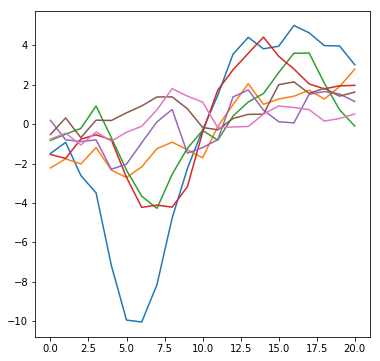

In [29]:
_ = plt.plot(x_detect[200])

In [20]:
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

In [21]:
amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


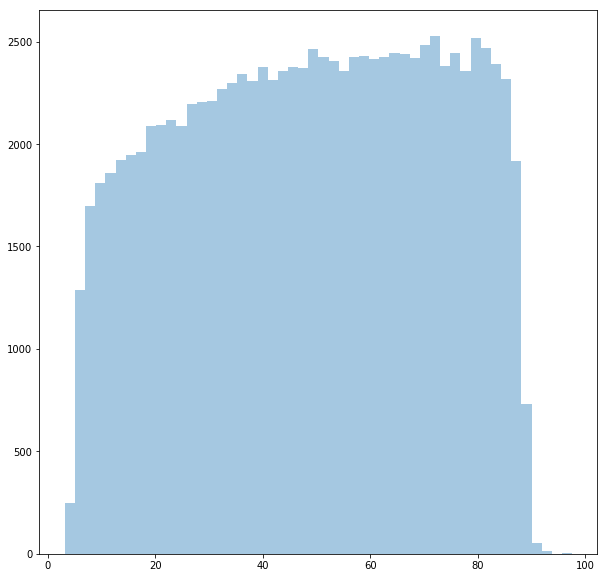

In [22]:
_ = sns.distplot(amps_positive, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


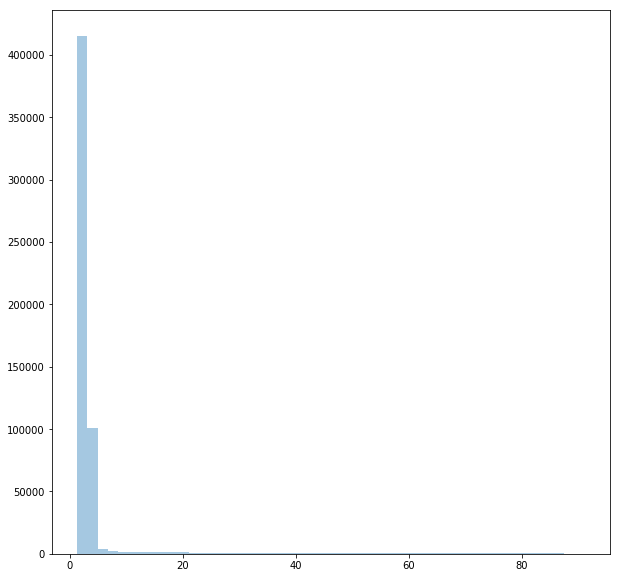

In [23]:
_ = sns.distplot(amps_negative, kde=False)

# Training

In [11]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001

## Detector training

In [12]:
import util

In [13]:
detectnet_name = path.join('models', 'detect-'+util.directory()+'.ckpt')
n_filters_detect = [8, 4]

In [74]:
print(detectnet_name)

models/detect-26-Jun-2018@14-32-34.ckpt


In [75]:
NeuralNetDetector.train(x_detect, y_detect,
                        n_filters_detect, n_iter,
                        n_batch, l2_reg_scale,
                        train_step_size,
                        detectnet_name)

INFO:yass.neuralnetwork.model_detector:Training detector network...
12492501it [01:39, 253007.71it/s]                   INFO:yass.neuralnetwork.model_detector:Approximate training true positive rate: 1.0, false positive rate: 0.0
12502500it [01:39, 125249.96it/s]
INFO:yass.neuralnetwork.model_detector:Saving detector network parameters...


## Triage training

In [43]:
path_to_triage = path.join('models', 'triage-'+util.directory()+'.ckpt')
filters_triage = [8, 4]
_, waveform_length, n_neighbors = x_triage.shape

In [41]:
print(path_to_triage)

models/triage-26-Jun-2018@22-02-58.ckpt


(150012, 21, 7)

In [48]:
triage = NeuralNetTriage(path_to_triage, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=5000)
triage.fit(x_triage, y_triage)

INFO:yass.neuralnetwork.model_triage:Training triage network...

 95%|█████████▌| 4753/5000 [00:01<00:14, 17.35it/s]
5995it [00:01, 24.76it/s]                          
7381it [00:02, 35.35it/s]
8911it [00:02, 50.45it/s]
10585it [00:02, 71.97it/s]
12403it [00:02, 102.63it/s]
14365it [00:02, 146.28it/s]
16471it [00:02, 208.32it/s]
18721it [00:02, 296.38it/s]
21115it [00:02, 421.03it/s]
23653it [00:02, 596.95it/s]
26335it [00:02, 844.30it/s]
29161it [00:03, 1190.15it/s]
32131it [00:03, 1670.09it/s]
35245it [00:03, 2330.57it/s]
38503it [00:03, 3224.64it/s]
41905it [00:03, 4421.66it/s]
45451it [00:03, 5985.24it/s]
49141it [00:03, 7962.67it/s]
52975it [00:03, 10395.56it/s]
56953it [00:03, 13279.99it/s]
61075it [00:04, 16626.98it/s]
65341it [00:04, 20184.85it/s]
69751it [00:04, 23847.61it/s]
74305it [00:04, 27638.42it/s]
79003it [00:04, 31259.52it/s]
83845it [00:04, 34523.27it/s]
88831it [00:04, 37546.63it/s]
93961it [00:04, 40262.38it/s]
99235it [00:04, 42680.98it/s]
104653it [00:04, 45222.

3649051it [00:24, 307196.37it/s]
3681541it [00:24, 308547.06it/s]
3714175it [00:24, 310739.16it/s]
3746953it [00:24, 310847.05it/s]
3779875it [00:24, 309643.65it/s]
3812941it [00:25, 310523.29it/s]
3846151it [00:25, 315474.58it/s]
3879505it [00:25, 317596.04it/s]
3913003it [00:25, 319008.12it/s]
3946645it [00:25, 320765.85it/s]
3980431it [00:25, 321084.08it/s]
4014361it [00:25, 322010.77it/s]
4048435it [00:25, 325769.58it/s]
4082653it [00:25, 326623.19it/s]
4117015it [00:26, 325721.38it/s]
4151521it [00:26, 326127.78it/s]
4186171it [00:26, 327434.04it/s]
4220965it [00:26, 329379.01it/s]
4255903it [00:26, 331494.18it/s]
4290985it [00:26, 332634.16it/s]
4326211it [00:26, 334186.00it/s]
4361581it [00:26, 335315.63it/s]
4397095it [00:26, 335932.42it/s]
4432753it [00:26, 338023.63it/s]
4468555it [00:27, 339499.07it/s]
4504501it [00:27, 341168.82it/s]
4540591it [00:27, 342445.28it/s]
4576825it [00:27, 344266.68it/s]
4613203it [00:27, 345774.92it/s]
4649725it [00:27, 347025.24it/s]
4686391it 

TypeError: save_triage_network_params() got an unexpected keyword argument 'waveform_length'

In [49]:
waveform[:, :, :7].shape

(226578, 21, 7)

In [39]:
triage.predict(waveform)

array([ True, False, False, ...,  True,  True, False])

## Autoencoder training

In [29]:
ae_name = path.join('models', 'ae-'+util.directory()+'.ckpt')
n_features = 3
n_batch = 1024
n_iter = 10000
train_step_size =  0.0001

In [30]:
ae_name

'models/ae-26-Jun-2018@19-48-41.ckpt'

In [32]:
AutoEncoder.train(x_ae, y_ae, n_features, n_iter,
                  n_batch, train_step_size, ae_name)

INFO:yass.neuralnetwork.model_autoencoder:Training autoencoder network...


# Predict

In [16]:
detector_to_load = 'models/detect-26-Jun-2018@14-32-34.ckpt'
triager_to_load = 'models/triage-26-Jun-2018@14-35-00.ckpt'
ae_to_load = 'models/ae-26-Jun-2018@19-48-41.ckpt'

In [17]:
output_dir = 'tmp/'

(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

INFO:yass.preprocess.run:Output dtype for transformed data will be float32


In [18]:
explorer_std = RecordingExplorer(path_to_standarized,
                                 path_to_geom=None,
                                 spike_size=15, neighbor_radius=70)

In [19]:
_data = explorer_std.reader.data
window_size = 350000
idx = gt[105963, 0]
data = _data[idx-window_size:idx+window_size, :]

In [20]:
data.shape

(700000, 49)

## Detect predict

In [29]:
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)

In [30]:
output_names = ('spike_index', 'waveform', 'probability')
(spike_index,
 waveform,
 proba) = detector.predict(data, output_names=output_names)

In [31]:
# TODO: fix dimenstion mismatch in waveform outout
print(data.shape, spike_index.shape, waveform.shape, proba.shape)

(700000, 49) (226578, 2) (226578, 21, 19) (700000, 49)


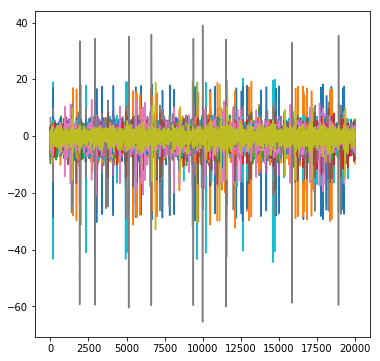

In [154]:
_ = plt.plot(data)

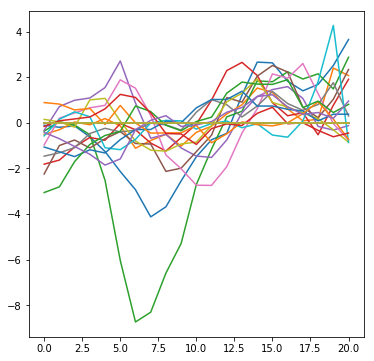

In [86]:
_ = plt.plot(waveform[0, :])

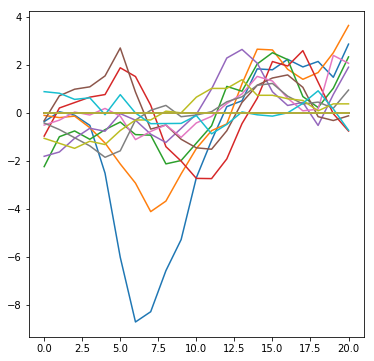

In [87]:
_ = plt.plot(waveform[1, :])

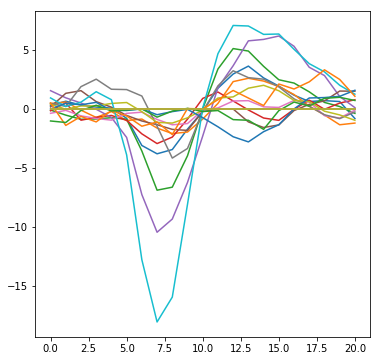

In [88]:
_ = plt.plot(waveform[2, :])

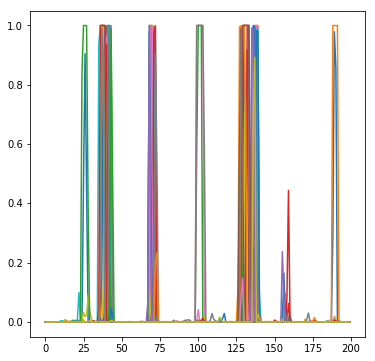

In [89]:
_ = plt.plot(proba)

## Triage predict

In [27]:
triager = NeuralNetTriage.load_from_file(triager_to_load,
                                         threshold=0.5)

In [32]:
# TODO: fix dimenstion mismatch in waveform outout
idx_clean = triager.predict(waveform[:, :, :7])

In [33]:
idx_clean

array([ True,  True, False, ...,  True, False, False])

## benchmark

In [24]:
# %%timeit
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)
output_names = ('spike_index', 'waveform', 'probability')
(spike_index,
 waveform,
 proba) = detector.predict(data, output_names=output_names)

triager = NeuralNetTriage(triager_to_load, threshold=0.5)

idx_clean = triager.predict(waveform[:, :, :7])

In [22]:
%%timeit
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)
# output_names = ('spike_index', 'waveform', 'probability')
# (spike_index,
#  waveform,
#  proba) = detector.predict(data, output_names=output_names)

triager = NeuralNetTriage(triager_to_load, detector, threshold=0.5)

idx_clean = triager.predict(data)

1.82 s ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## chaining

In [35]:
detector = NeuralNetDetector(detector_to_load, 0.5,
                             CONFIG.channel_index)

triager = NeuralNetTriage(triager_to_load, threshold=0.5,
                          input_tensor=detector.waveform_tf[:, :, :7])

autoencoder = AutoEncoder(ae_to_load,
                          input_tensor=detector.waveform_tf)

In [36]:
import tensorflow as tf

out = (detector.spike_index_tf, triager.idx_clean, autoencoder.score_tf)

with tf.Session() as sess:
    detector.restore(sess)
    triager.restore(sess)
    autoencoder.restore(sess)
    
    spike_index_, idx_clean_, score_ = sess.run(out, feed_dict={detector.x_tf: data})

In [26]:
np.testing.assert_array_equal(spike_index, spike_index_)
np.testing.assert_array_equal(idx_clean, idx_clean_)